In [1]:
#Adds higher directory to path to access /ATS
import sys
sys.path.append("../")

from ATS.general import *
from ATS.QAQC import *

import pandas as pd
import matplotlib.pyplot as plt

# Set the DataFram in pandas to show all columns and 1000 rows. Display plots inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

2021-10-08 21:30:45.494255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-08 21:30:45.494299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load and Subset Data

<Item title:"SAC_WR_CCRS_Woody_Cover_RT" type:Feature Layer Collection owner:Anooshi>
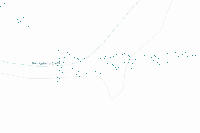

In [3]:
# Load data from arcGIS online
output = arcGIS_data_load('d2a03b3d9a97426fbecbda42b45ec1de')

layer = output['data0']
records = output['table0']
feature_service = output['feature_service']

In [4]:
#Match record GUID string format to layer GLOBALID
records['Feature_ID'] = records['Feature_ID'].str.strip('{}')
records['Feature_ID'] = records['Feature_ID'].str.lower()

In [5]:
# Merge related table and feature layer
data = layer.merge(records, left_on='GlobalID', right_on='Feature_ID', how='inner')
data = data.drop(columns=['GlobalID_x','Feature_ID'])
data = data.rename(columns={'GlobalID_y':'Record_GlobalID' ,'OBJECTID_x':'Point_ID','OBJECTID_y':'Record_ID'})
data.head()

,Point_ID,Habitat,BHR_Site,Observer_1,Observer_2,Observation_Date,FldPntTyp,Comments,Plot_Code,Azimuth,SHAPE,Record_ID,Height_Cat,Species_Sci,Record_GlobalID,Woody
0,1,Central Coast Riparian Scrub,SAC,Roger Stephens,Janel Mayo,2018-08-08 03:41:04,Intended Habitat,None,CCRS1,145,"{'x': 6181457.768742725, 'y': 2037354.15887631...",1,1,Baccharis pilularis,f813a0bb-175e-4a4b-9b78-5e182a35cc4b,True
1,1,Central Coast Riparian Scrub,SAC,Roger Stephens,Janel Mayo,2018-08-08 03:41:04,Intended Habitat,None,CCRS1,145,"{'x': 6181457.768742725, 'y': 2037354.15887631...",180,2,Baccharis pilularis,642793ce-469f-4d71-ad2d-291c12bbc048,True
2,2,Central Coast Riparian Scrub,SAC,Roger Stephens,Janel Mayo,2018-08-08 03:32:51,Intended Habitat,None,CCRS2,313,"{'x': 6181462.124048978, 'y': 2037380.68277339...",2,1,Bare Ground (none),05ff49c3-8164-48ad-bd6f-d35dc780f071,None
3,4,Central Coast Riparian Scrub,SAC,Janel Mayo,Roger Stephens,2018-08-09 00:43:51,Intended Habitat,None,CCRS4,192,"{'x': 6181536.38046214, 'y': 2037269.683651566...",3,1,Bare Ground (none),d86e8342-8adb-4a8f-9578-50825f4f4790,None
4,5,Central Coast Riparian Scrub,SAC,Roger Stephens,Janel Mayo,2018-08-09 00:12:35,Intended Habitat,None,CCRS5,132,"{'x': 6181469.878298551, 'y': 2037365.10898564...",4,1,Bare Ground (none),45dd5130-101b-422f-ae37-456dcfb89cea,None


In [6]:
#Subset data by year
sYear = input("Start Year? (YYYY)")
sub = year_subset(data, sYear)

Start Year? (YYYY) 2020

Analysis for 2020-10-01 07:00 UTC to 2021-10-01 07:00 UTC
ERROR: No Data in Subset


# Update Woody Column through API

In [6]:
# Get Species List
pltDir = r"Script Support Files/SAC Master Plant Species List 20191114.xlsx"
pltSheet = "Year 5 Plant Species List"

verif = input("Current Plant Species List file location:\n"+pltDir+"\nCurrent Sheet Name:\n"+pltSheet+"\n\nIs this correct? (Y/N)")


if verif=="Y":
    # Will need to update this file locally on the G drive and change the sheet name
    pltLst = pd.read_excel(pltDir, pltSheet)
    
    #Clean lists
    for col in ['Woody Native Plant','Species']:
        pltLst[col] = text_cleaner(pltLst[col])
    
    #Get woody
    Woody = pltLst.loc[pltLst['Woody Native Plant'] == "x", 'Species'].tolist()

    
    print("Done")
    
else:
    print("\nChange directory and sheet in code")

Current Plant Species List file location:
Script Support Files/SAC Master Plant Species List 20191114.xlsx
Current Sheet Name:
Year 5 Plant Species List

Is this correct? (Y/N) Y

Done


In [7]:
#Update records through API
# Get all records
VC_records = feature_service.tables[0].query(return_all_records=True)

edits = [] #Edits to be sent

#loop through each feature
for feature in VC_records.features:
    
    species = feature.attributes['Species_Sci']
    update_flag = False

    if species in Woody:
        feature.attributes['Woody'] = 'True'
        update_flag = True
        
    #append edits if one was made
    if update_flag:
        edits.append(feature)

        
#send updates if edit was made
if edits:
    result = feature_service.tables[0].edit_features(updates=edits)

    #Check if update was successful
    fail_flag = False
    for item in result['updateResults']:
        if not item['success']:
            fail_flag = True
            print('Could not update feature, Object ID: ',item['objectId'])

    if not fail_flag:
        print('Successfully updated features')
        
else:
    print('No edits made')

Successfully updated features


# QAQC

In [8]:
validate_domains(feature_service)



Table/Layer:  SAC_WR_CCRS_Woody_Cover_Obs


No Mismatches Found


Table/Layer:  SAC_WR_CCRS_Woody_Cover


The following entries are not within the domain:


,Field,Data
0,Observer_1,{Janel Mayo}
0,Observer_2,{Janel Mayo}


In [9]:
QAQC_whitespace(data, exclude_cols=['Comments'],objectID = ['Record_ID'])



Analysis for: Habitat
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: SHAPE
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Species_Sci
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Observer_1
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Plot_Code
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Woody
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: BHR_Site
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: FldPntTyp
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white spac

In [11]:
#Find blank entries for all years
find_blank_entries(data, exclude_cols=['Comments','Woody'])

No blank BHR_Site
No blank SHAPE
No blank Observer_1
No blank Record_GlobalID
No blank FldPntTyp
No blank Observation_Date
No blank Plot_Code
No blank Point_ID
No blank Record_ID
No blank Habitat
No blank Azimuth
No blank Species_Sci
No blank Observer_2
No blank Height_Cat


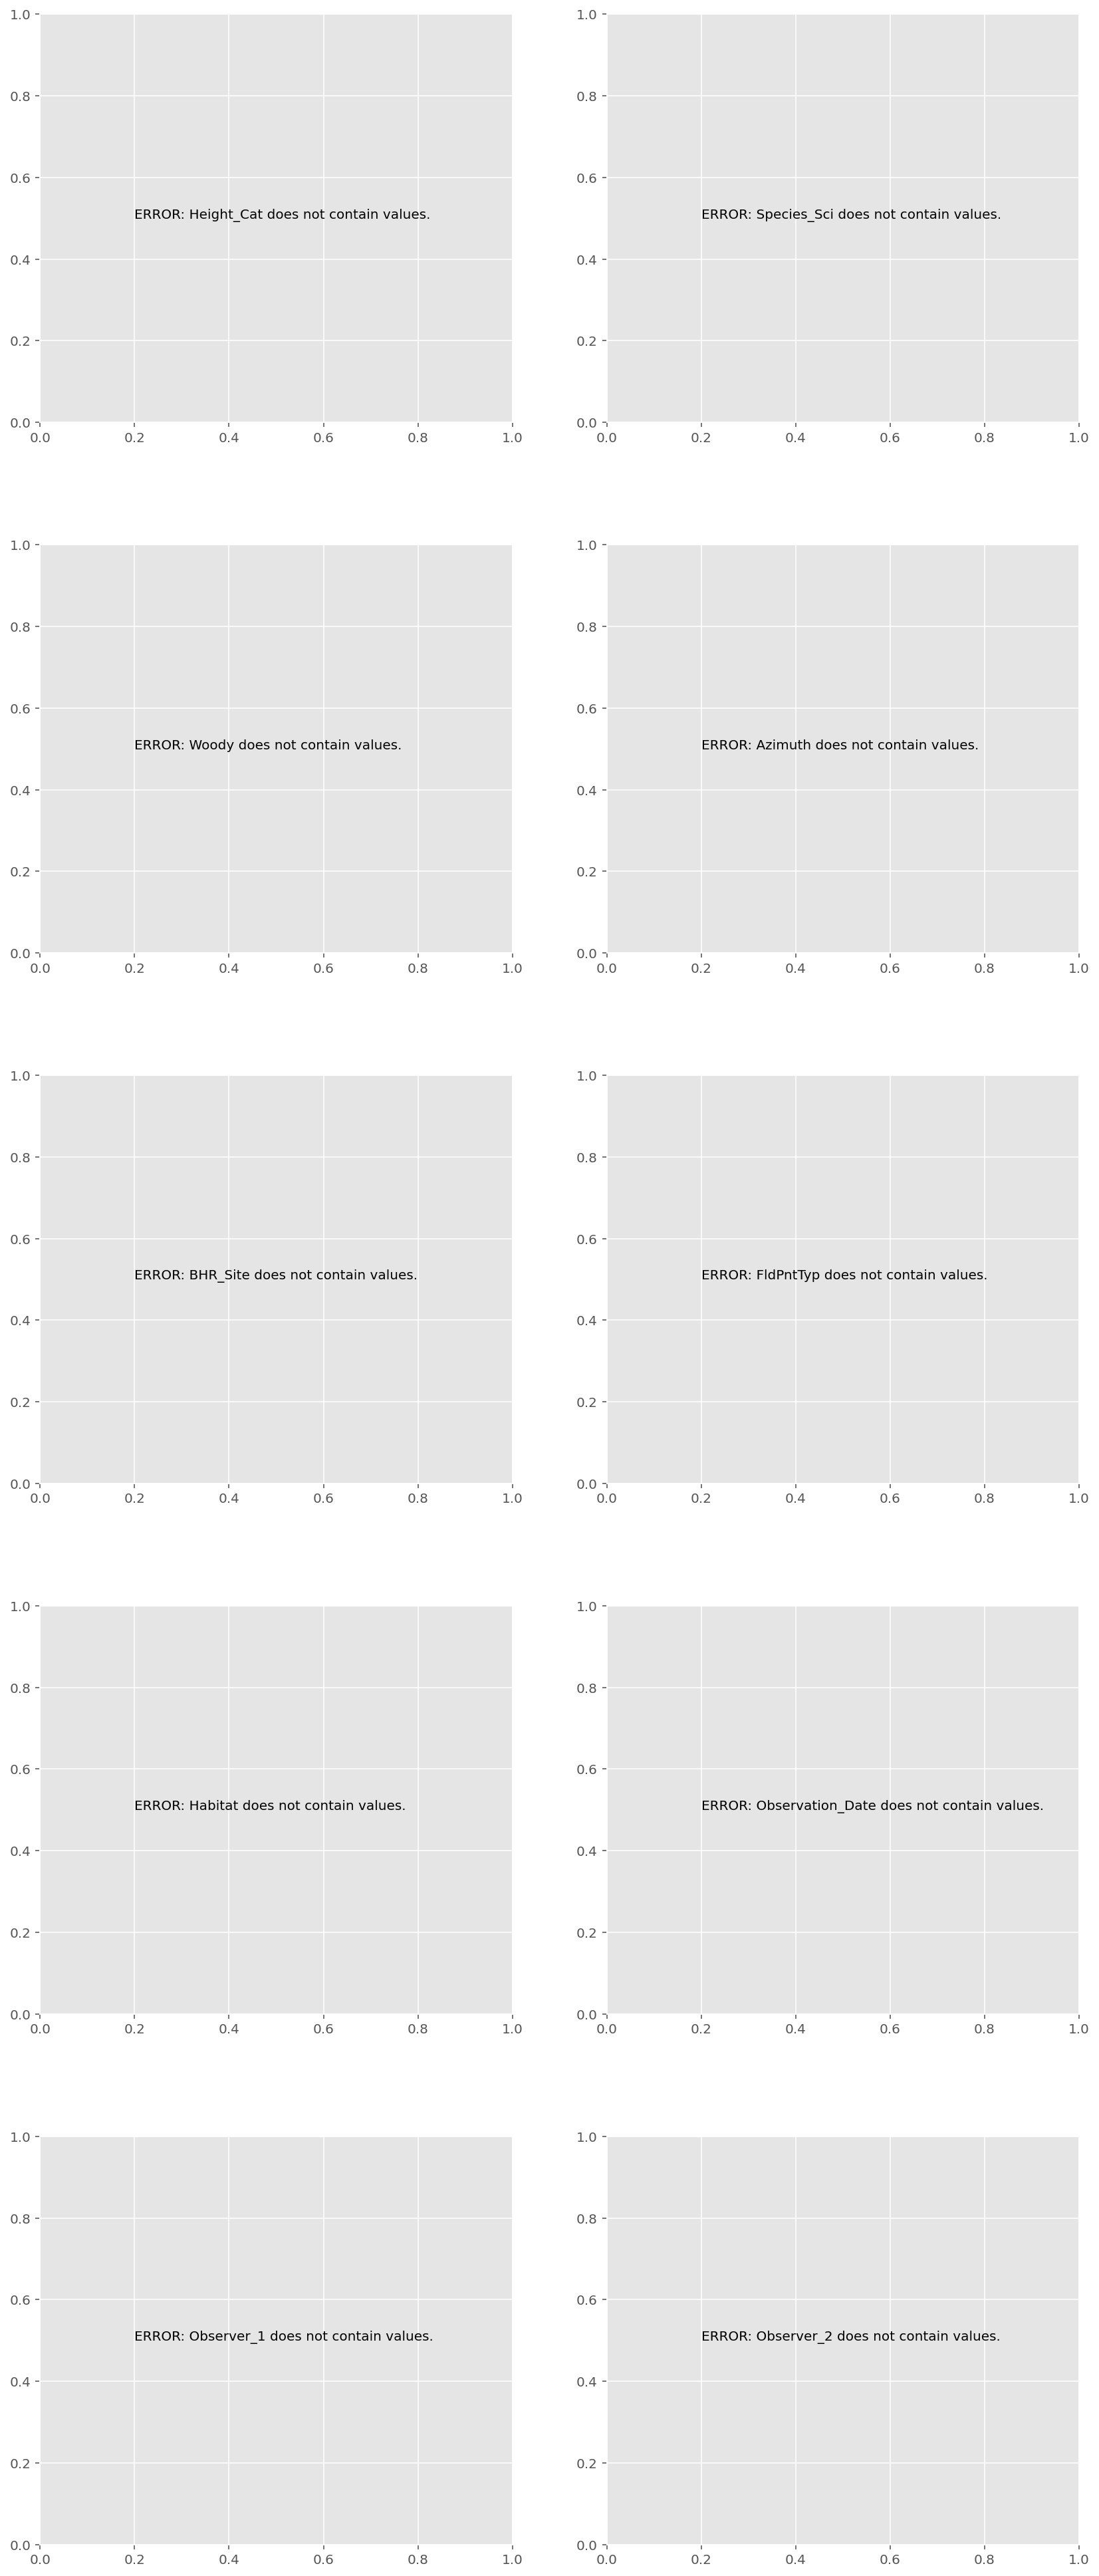

In [12]:
QAQC_plot(sub, ['Height_Cat', 'Species_Sci', 'Woody', 'Azimuth', 'BHR_Site',
       'FldPntTyp', 'Habitat', 'Observation_Date', 'Observer_1', 'Observer_2'])

In [30]:
QAQC_attachment_filenames(feature_service)


No mislabeled photos found for layer/table SAC_WR_CCRS_Woody_Cover



No attachments for layer/table SAC_WR_CCRS_Woody_Cover_Obs


# Analysis

In [41]:
#Convert string to boolean for presence/absence columns
sub['Woody'] = (sub['Woody']=='True')

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [42]:
#Remove unintended habitat points
sub = sub.loc[sub["FldPntTyp"]=="Intended Habitat",:]

In [43]:
#Count of valid points collected
pointCount = sub.groupby('Habitat').Plot_Code.nunique()
print("Count of Observed Points by Habitat:")
print(pointCount.to_string(index=True), '\n\n')

print("Total Count:\n", sub.Plot_Code.nunique())

Count of Observed Points by Habitat:
Habitat
Central Coast Riparian Scrub    71
Willow Riparian                 70 


Total Count:
 141


In [44]:
#Section A
# Count of plots with native woody matches by habitat
print("\nCount of plots with woody plants by habitat:")
Count_by_ID_Hab = sub.groupby(['Plot_Code','Habitat']).Woody.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# % of sampling sites that contained a woody plant (Max 1 hit per pole, N = count of  poles)
print("\n% of sampling sites that contained a woody plant :\n")
print (round((nHits/pointCount)*100,2).to_string(index=True))


Count of plots with woody plants by habitat:
Habitat
Central Coast Riparian Scrub    34.0
Willow Riparian                 30.0

% of sampling sites that contained a woody plant :

Habitat
Central Coast Riparian Scrub    47.89
Willow Riparian                 42.86


In [45]:
#Section C
# Count of woody native plants by habitat, excluding duplicate and triplicate observations of the same species within a plot.
uniqueSpec = sub.groupby(['Habitat','Plot_Code','Species_Sci']).Woody.any()
unique_hits = uniqueSpec.groupby(['Habitat']).sum()
print("\nCount of woody native plants by habitat, excluding duplicates and triplicates:")
print(unique_hits)

# % of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3)
print('\n\n% of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3) excluding repetative species observations at a given point ')
print(round((unique_hits/(pointCount*3))*100,2).to_string(index=True))


Count of woody native plants by habitat, excluding duplicates and triplicates:
Habitat
Central Coast Riparian Scrub    39.0
Willow Riparian                 40.0
Name: Woody, dtype: float64


% of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3) excluding repetative species observations at a given point 
Habitat
Central Coast Riparian Scrub    18.31
Willow Riparian                 19.05


In [46]:
# Section D
# Count of woody native plants by habitat, excluding duplicate and triplicate observations of the same species within a plot.
uniqueSpec = sub.groupby(['Habitat','Plot_Code','Species_Sci']).Woody.any()
unique_hits = uniqueSpec.groupby(['Habitat']).sum()
print("\nCount of woody native plants by habitat, excluding duplicates and triplicates:")
print(unique_hits)

# % of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles)
print('\n\n% of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles) ')
print(round((unique_hits/(pointCount))*100,2).to_string(index=True))



Count of woody native plants by habitat, excluding duplicates and triplicates:
Habitat
Central Coast Riparian Scrub    39.0
Willow Riparian                 40.0
Name: Woody, dtype: float64


% of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles) 
Habitat
Central Coast Riparian Scrub    54.93
Willow Riparian                 57.14


In [47]:
#Section E
# Count of woody plants by habitat
Count_by_ID_Hab = sub.groupby(['Plot_Code','Habitat']).Woody.sum()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print("\nCount of woody plants habitat (no exclusions):")
print(nHits.to_string())

# % Sum of absolute cover of woody plants (infinite hits per pole, N = count of  poles)
print("\nSum of absolute Woody Vegetation Cover by Habitat:\n")
print (round((nHits/pointCount)*100,2).to_string(index=True))

Count_by_ID_Hab


Count of woody plants habitat (no exclusions):
Habitat
Central Coast Riparian Scrub    64.0
Willow Riparian                 56.0

Sum of absolute Woody Vegetation Cover by Habitat:

Habitat
Central Coast Riparian Scrub    90.14
Willow Riparian                 80.00


Plot_Code  Habitat                     
CCRS1      Central Coast Riparian Scrub    1.0
CCRS10     Central Coast Riparian Scrub    0.0
CCRS11     Central Coast Riparian Scrub    0.0
CCRS12     Central Coast Riparian Scrub    0.0
CCRS13     Central Coast Riparian Scrub    0.0
CCRS14     Central Coast Riparian Scrub    2.0
CCRS15     Central Coast Riparian Scrub    0.0
CCRS16     Central Coast Riparian Scrub    0.0
CCRS17     Central Coast Riparian Scrub    0.0
CCRS18     Central Coast Riparian Scrub    3.0
CCRS19     Central Coast Riparian Scrub    2.0
CCRS2      Central Coast Riparian Scrub    0.0
CCRS20     Central Coast Riparian Scrub    2.0
CCRS21     Central Coast Riparian Scrub    2.0
CCRS22     Central Coast Riparian Scrub    1.0
CCRS23     Central Coast Riparian Scrub    0.0
CCRS24     Central Coast Riparian Scrub    2.0
CCRS25     Central Coast Riparian Scrub    0.0
CCRS26     Central Coast Riparian Scrub    2.0
CCRS27     Central Coast Riparian Scrub    5.0
CCRS28     Central C

In [48]:
#Section by Height Category (1 woody hit per layer)

# Count of plots with native woody matches by habitat and Height Category
Count_by_Height_Cat = sub.groupby(['Plot_Code','Habitat', 'Height_Cat']).Woody.any()
cHits = Count_by_Height_Cat.groupby(['Habitat','Height_Cat']).sum()
print("\nCount of plots with woody plants by habitat and height:")
print(cHits.to_string())

# % of height categories that contained woody plant (Max 1 hit per height category, N = count of  poles)
print("\n% of height categories that contained a woody plant:\n")
print(round((cHits/pointCount)*100,2).to_string(index=True))




Count of plots with woody plants by habitat and height:
Habitat                       Height_Cat
Central Coast Riparian Scrub  1             13.0
                              2             27.0
                              3             19.0
Willow Riparian               1             2.0 
                              2             20.0
                              3             26.0

% of height categories that contained a woody plant:

Habitat                       Height_Cat
Central Coast Riparian Scrub  1             18.31
                              2             38.03
                              3             26.76
Willow Riparian               1             2.86 
                              2             28.57
                              3             37.14


In [49]:
# Method A for only Salix sp.
salix_sub = sub.loc[sub.Species_Sci.isin(['Salix exigua','Salix gooddingii','Salix laevigata','Salix lasiolepis']),:]

# Count of plots with Salix matches by habitat
print("\nCount of plots with Salix trees by habitat:")
Count_by_ID_Hab = salix_sub.groupby(['Plot_Code','Habitat']).Woody.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# % of sampling sites that contained a Salix (Max 1 hit per pole, N = count of  poles)
print("\n% of sampling sites that contained a Salix:\n")
print (round((nHits/pointCount)*100,2).to_string(index=True))




Count of plots with Salix trees by habitat:
Habitat
Central Coast Riparian Scrub    18.0
Willow Riparian                 28.0

% of sampling sites that contained a Salix:

Habitat
Central Coast Riparian Scrub    25.35
Willow Riparian                 40.00


In [50]:
# Method D for only Salix sp. 

# Count of woody native plants by habitat, excluding duplicate and triplicate observations of the same species within a plot.
uniqueSpec = salix_sub.groupby(['Habitat','Plot_Code','Species_Sci']).Woody.any()
unique_hits = uniqueSpec.groupby(['Habitat']).sum()
print("\nCount of woody native plants by habitat, excluding duplicates and triplicates:")
print(unique_hits)

# % of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles)
print('\n\n% of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles)')
print(round((unique_hits/(pointCount))*100,2).to_string(index=True))


Count of woody native plants by habitat, excluding duplicates and triplicates:
Habitat
Central Coast Riparian Scrub    18.0
Willow Riparian                 37.0
Name: Woody, dtype: float64


% of observations that contain a woody plant exluding repetative species (infinite hits per pole, N = count of poles)
Habitat
Central Coast Riparian Scrub    25.35
Willow Riparian                 52.86


# Sample Size Analysis

In [51]:
# This analysis determines how many sample points are necessary. 

#Utilizing method A
# Count of plots with native woody matches by habitat
print("\nCount of plots with woody plants by habitat:")
Count_by_ID_Hab = sub.groupby(['Plot_Code','Habitat']).Woody.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# % of sampling sites that contained a woody plant (Max 1 hit per pole, N = count of  poles)
print("\n% of sampling sites that contained a woody plant :\n")
print (round((nHits/pointCount)*100,2).to_string(index=True))


Count of plots with woody plants by habitat:
Habitat
Central Coast Riparian Scrub    34.0
Willow Riparian                 30.0

% of sampling sites that contained a woody plant :

Habitat
Central Coast Riparian Scrub    47.89
Willow Riparian                 42.86


In [117]:
import statistics as st

WR = Count_by_ID_Hab.xs('Willow Riparian', level=1)

means = []
i = 2
while i <= 70:
    variances = []
    j = 0
    while j <= 5000:
        crt_sample = WR.sample(i)
        variances.append(crt_sample.var())
        j += 1
    means.append(st.mean(variances))
    i += 1
    print(i)
    
print(means)

3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71
[0.2488502299540092, 0.25194961007798444, 0.2481836965940145, 0.24859028194361132, 0.24958341665000336, 0.24756001180716236, 0.24879666923758104, 0.24771156879735165, 0.24935235175187187, 0.2488338695897184, 0.24865784418873801, 0.24865796071554921, 0.24742524022667992, 0.24774092800487524, 0.24862777444511097, 0.24837973581754236, 0.24850846824099235, 0.24830121694959256, 0.24837295698754988, 0.2487969072852096, 0.2487805469209188, 0.24843410764487417, 0.24867816291814102, 0.24838698926881295, 0.2484613846461477, 0.2485109815643709, 0.2485907580388684, 0.24829713860183625, 0.24819128128397308, 0.2486178033210562, 0.24825095464778013, 0.24818559015469632, 0.2486622105168984, 0.24842426472688656, 0.24844126412812675, 0.24823473743689706, 0.2485207083761057, 0.24844639709035252, 0.2485888719691959, 0.24849688598865594, 0.24862019466025492, 0.24843026964928167, 0.24846299239095096, 0.248438595109261, 0.24839283351059258, 0.24835402947162646, 0.2483046830350242, 0.24844622912152262, 0.2

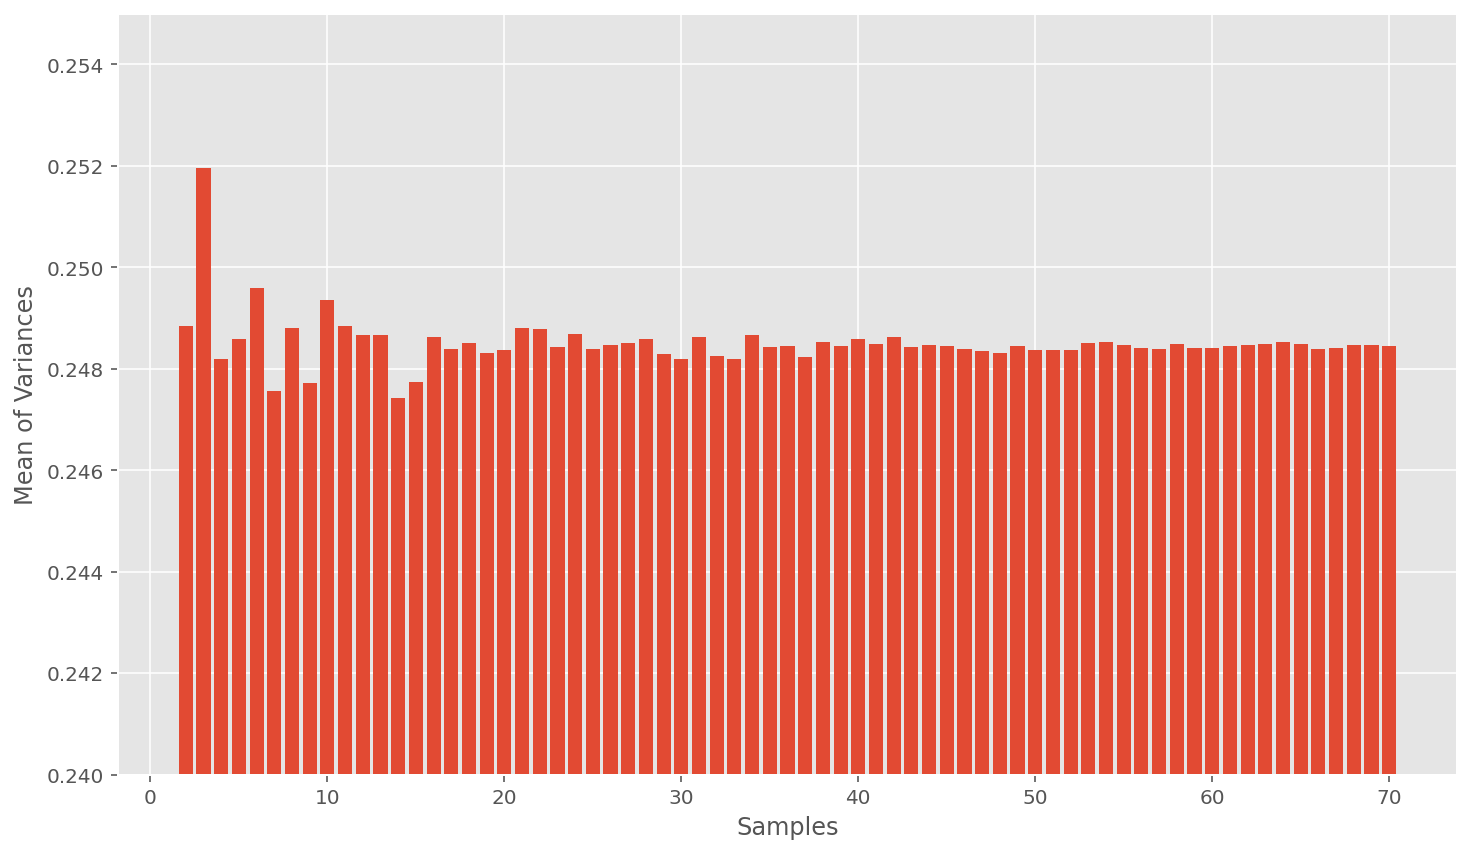

In [118]:
#Create position of bars (x)
y_pos = np.arange(len(means))+2
 
# Create bars
plt.bar(y_pos, means)
 
# Create labels
plt.xlabel('Samples')
plt.ylabel('Mean of Variances')

# Y limit
plt.ylim(0.24, .2550)
# Show graphic
plt.show()

In [115]:
import statistics as st

WR = Count_by_ID_Hab.xs('Willow Riparian', level=1)

variances = []
i = 2
while i <= 70:
    means = []
    j = 0
    while j <= 1000:
        crt_sample = WR.sample(i)
        means.append(crt_sample.mean())
        j += 1
    variances.append(st.variance(means))
    i += 1
    print(i)
    
print(variances)

3
4


5
6


7


8
9


10


11


12


13
14


15
16


17


18
19


20


21


22
23


24
25


26


27


28
29


30
31


32


33
34


35


36
37


38


39
40


41


42


43


44


45


46
47


48


49
50


51


52
53


54


55
56


57
58


59


60


61


62


63
64


65


66


67
68


69
70


71
[0.1221063936063936, 0.07436829836829836, 0.06388061938061938, 0.04226765234765235, 0.036753857253857256, 0.030479928235030276, 0.027121503496503496, 0.025345395345395347, 0.020902477522477522, 0.020114761271786064, 0.01750412087912088, 0.01543140882785853, 0.014348997940834676, 0.014166651126651126, 0.011638205544455544, 0.010114307837491229, 0.010259209925876594, 0.00979617612304593, 0.009023736263736265, 0.007462822891394321, 0.008022675671436, 0.006789996393020967, 0.007095786158286157, 0.006519624375624376, 0.0055578859010811665, 0.005658876103320548, 0.004869780729474606, 0.004966643344764629, 0.004712536352536353, 0.0044996813800143665, 0.0038914913211788213, 0.0040083149174058265, 0.003601640573958913, 0.0034007641338253567, 0.0034432789432789434, 0.0030223757250784273, 0.0030948691197998676, 0.0028283366863248514, 0.0026543831168831166, 0.002388720143627937, 0.0024044878024469863, 0.002320473469202512, 0.002052992462083371, 0.0019394521527854856, 0.0019004181074124362, 0.00

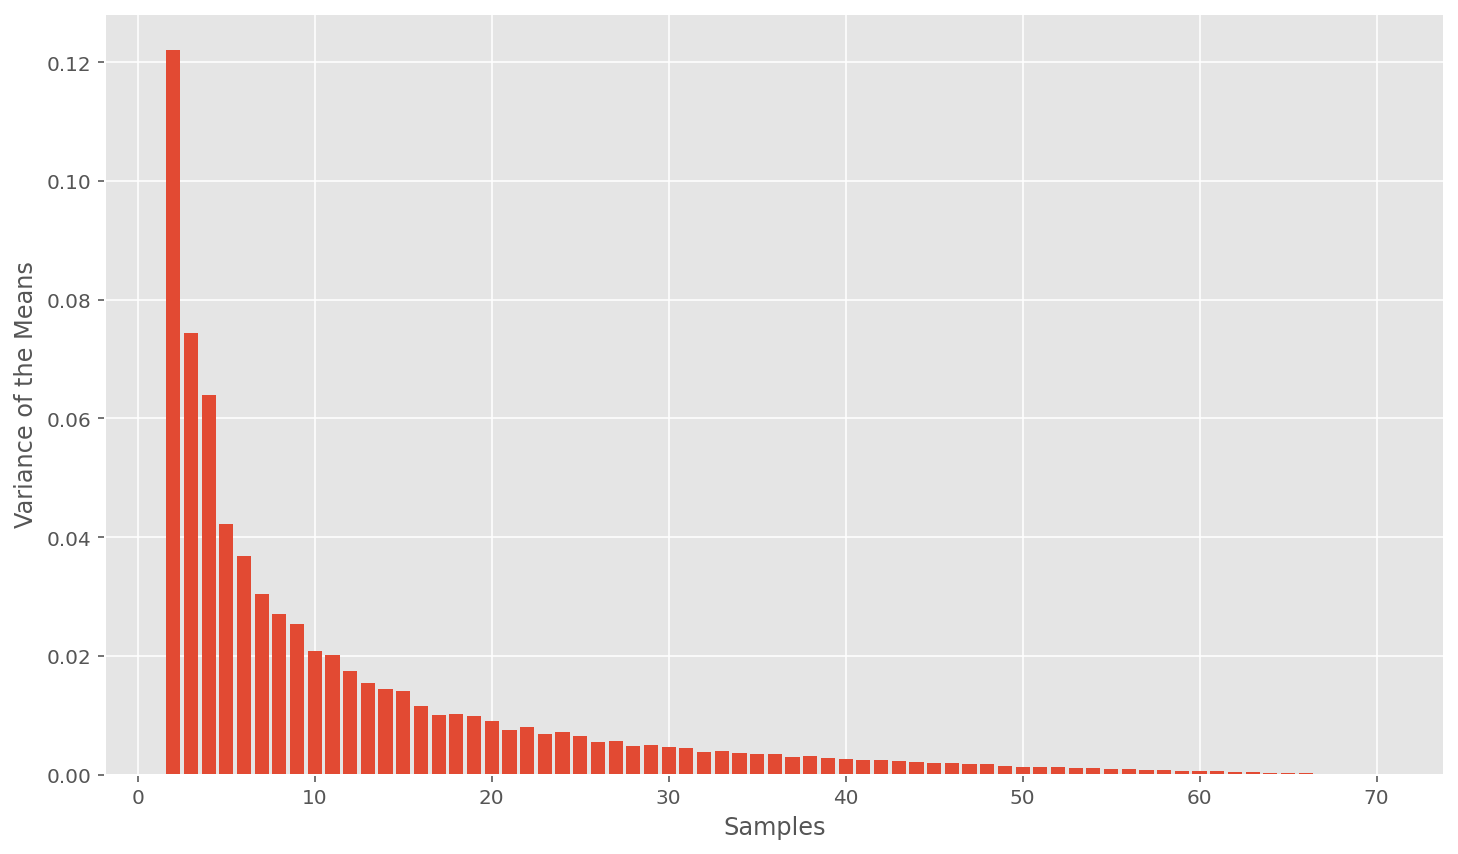

In [116]:
#Create position of bars (x)
y_pos = np.arange(len(variances))+2
 
# Create bars
plt.bar(y_pos, variances)
 
# Create labels
plt.xlabel('Samples')
plt.ylabel('Variance of the Means')

# Y limit
#plt.ylim(0.24, .2550)
# Show graphic
plt.show()

In [122]:
WR = Count_by_ID_Hab.xs('Willow Riparian', level=1)

mean_of_means = []
lower_CI = []
upper_CI = []
i = 2
while i <= 70:
    means = []
    j = 0
    while j <= 500:
        crt_sample = WR.sample(i)
        means.append(crt_sample.mean())
        j += 1
    mean_of_means.append(st.mean(means))
    
    lower_CI.append(np.percentile(means, 2.5))
    upper_CI.append(np.percentile(means, 97.5))
    i += 1
    print(i)
    


3
4


5
6
7


8
9


10
11
12


13
14


15
16


17
18
19


20
21


22
23


24
25


26
27


28
29


30
31


32
33


34
35


36
37


38
39
40


41
42
43


44
45


46
47
48


49
50
51


52
53


54
55


56
57
58


59
60


61
62
63


64
65
66


67
68


69
70


71


In [132]:
np.array(lower_CI)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07142857, 0.125     , 0.11111111, 0.2       , 0.18181818,
       0.16666667, 0.23076923, 0.21428571, 0.2       , 0.1875    ,
       0.23529412, 0.22222222, 0.26315789, 0.25      , 0.28571429,
       0.27272727, 0.26086957, 0.29166667, 0.28      , 0.26923077,
       0.2962963 , 0.28571429, 0.31034483, 0.3       , 0.29032258,
       0.3125    , 0.3030303 , 0.32352941, 0.31428571, 0.30555556,
       0.32432432, 0.31578947, 0.33333333, 0.325     , 0.34146341,
       0.33333333, 0.34883721, 0.34090909, 0.33333333, 0.34782609,
       0.34042553, 0.35416667, 0.34693878, 0.35      , 0.35294118,
       0.36538462, 0.37735849, 0.37037037, 0.36363636, 0.375     ,
       0.36842105, 0.37931034, 0.37288136, 0.38333333, 0.37704918,
       0.38709677, 0.3968254 , 0.3984375 , 0.4       , 0.39393939,
       0.40298507, 0.41176471, 0.42028986, 0.42857143])

In [142]:
upper = np.array(upper_CI)-np.array(mean_of_means)
lower = np.array(lower_CI)-np.array(mean_of_means)
CI = np.vstack([lower,upper])

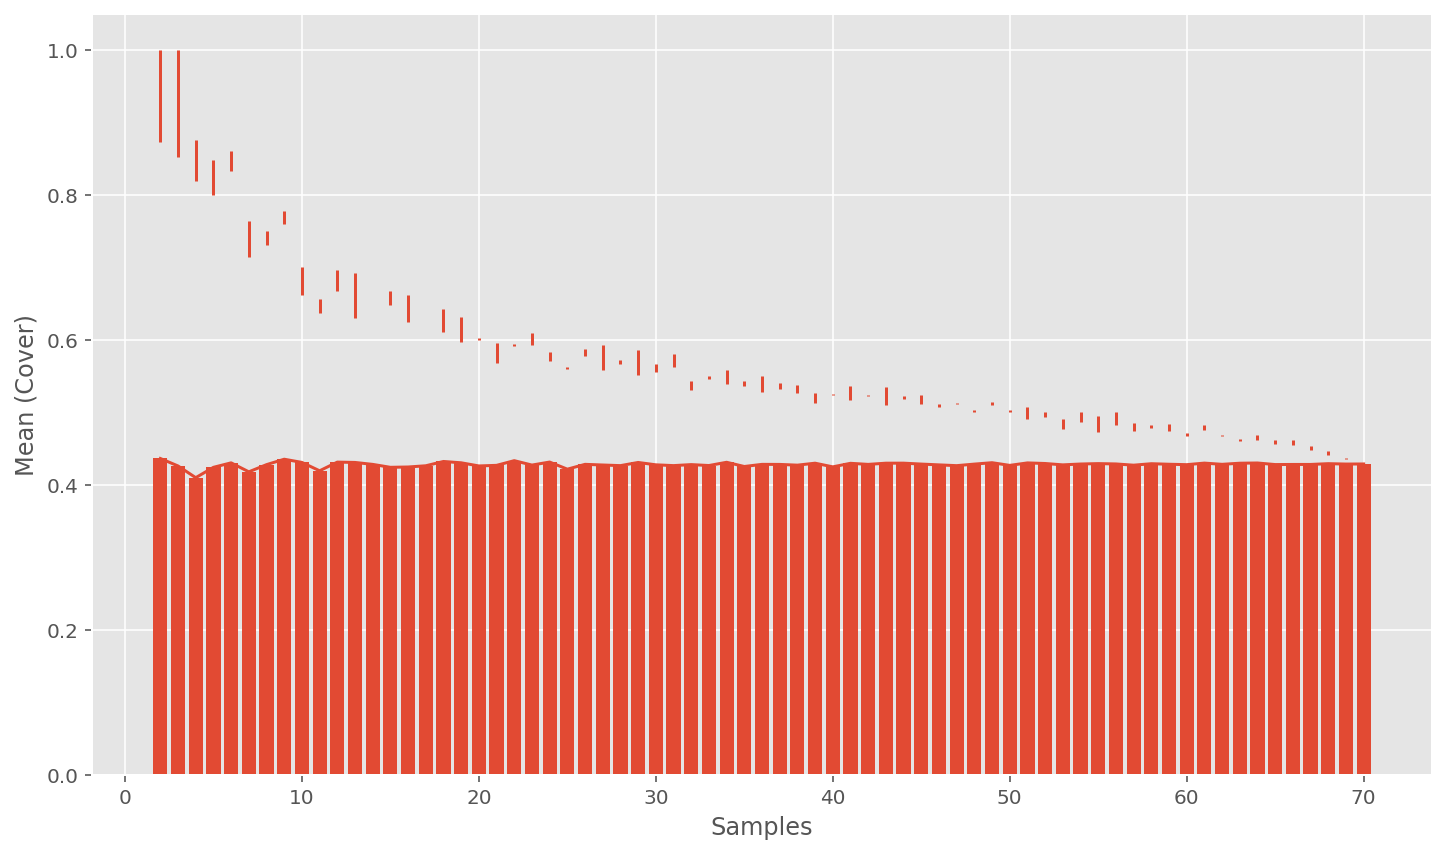

In [143]:
#Create position of bars (x)
y_pos = np.arange(len(mean_of_means))+2
 
# Create bars
plt.bar(y_pos, mean_of_means)
 
plt.errorbar(y_pos, mean_of_means, yerr=CI)
# Create labels
plt.xlabel('Samples')
plt.ylabel('Mean (Cover)')

# Y limit
#plt.ylim(0.24, .2550)
# Show graphic
plt.show()



# Export Excel Data Deliverable

In [23]:
(data.columns)

Index(['Point_ID', 'Habitat', 'BHR_Site', 'Observer_1', 'Observer_2',
       'Observation_Date', 'FldPntTyp', 'Comments', 'Plot_Code', 'Azimuth',
       'SHAPE', 'Record_ID', 'Height_Cat', 'Species_Sci', 'Record_GlobalID',
       'Woody'],
      dtype='object')

In [28]:
field_order = ['BHR_Site',
'Observation_Date', 
'Observer_1', 
'Observer_2',
'Plot_Code',
'Height_Cat', 
'Species_Sci', 
'Woody', 
'Habitat',
'Azimuth', 
'FldPntTyp',
'Comments',  
'Point_ID',
'Record_ID',
'Record_GlobalID',
'SHAPE'] 

In [29]:
export_data_deliverable(data, feature_service, field_order)

Exported to Outputs/SAC_WR_CCRS_Woody_Cover_Data_20200720.xlsx
